                                    
                                        EN3160 Assignment 2 on Fitting and Alignment
                                        
                                        

Name : S.M.R.K. Samarakoon                                                                             
Index No : 200556L

---
Question 1 
---

Largest Circle Parameters:
Radius (r): 9.742360096347989
Center (x, y): (106.0, 256.0)
Range of σ values used: Min = 3, Max = 10


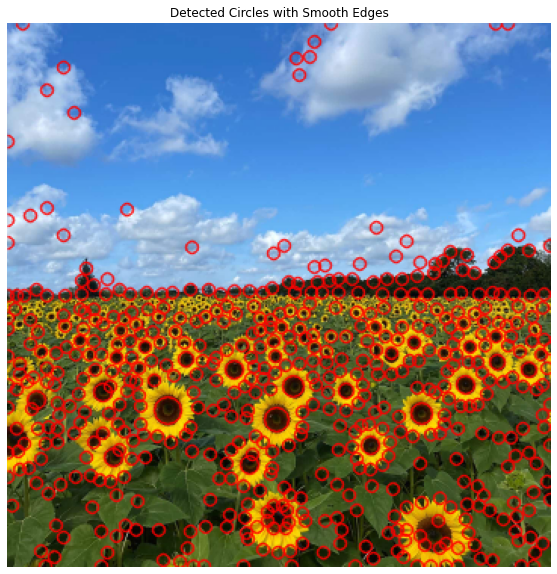

In [3]:
import cv2 as cv
import numpy as np
from skimage.feature import blob_log
import matplotlib.pyplot as plt
from math import sqrt

# Read the image
img = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv.GaussianBlur(gray, (9, 9), 0.1)
laplacian = cv.Laplacian(blurred, cv.CV_64F)

# Define parameters for blob detection
min_sigma = 3
max_sigma = 10
threshold = 4

# Detect blobs using Laplacian of Gaussians
blobs = blob_log(laplacian, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold)
blobs[:, 2] = blobs[:, 2] * sqrt(2)

# Find the largest circle by comparing their radii
if len(blobs) > 0:
    max_radius_index = np.argmax(blobs[:, 2])
    largest_circle_params = blobs[max_radius_index]
    y, x, r = largest_circle_params
    print(f"Largest Circle Parameters:")
    print(f"Radius (r): {r}")
    print(f"Center (x, y): ({x}, {y})")
else:
    print("No circles detected.")

# Report the range of σ values used
print(f"Range of σ values used: Min = {min_sigma}, Max = {max_sigma}")

# Draw circles on the original grayscale image
for blob in blobs:
    y, x, r = blob  # Blob format is (y, x, r)
    cv.circle(img, (int(x), int(y)), int(r), (0, 0, 255), thickness=1, lineType=cv.LINE_AA)  # Draw circles in white

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Circles with Smooth Edges')
plt.show()


---
Question 2
---

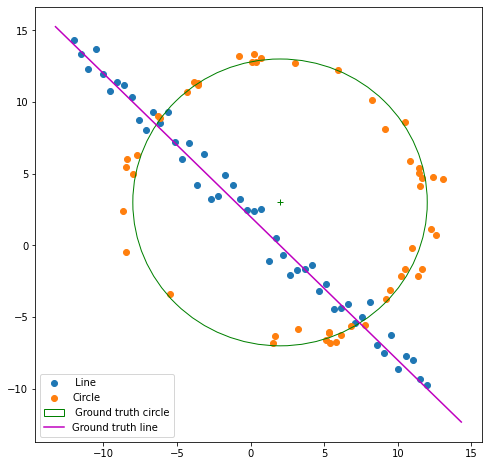

In [2]:
# Generation o f a Noisy Point Set Conforming to a Line and a Circle
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import tikzplotlib

# np . random . seed ( 0 )
N = 100
half_n = N//2
r = 10
x0_gt,y0_gt = 2,3 # Center
s = r /16

t = np.random.uniform (0 ,2*np.pi,half_n)

n = s*np.random.randn( half_n )

x,y = x0_gt + (r + n)*np.cos(t) , y0_gt + (r + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1) ,y.reshape(half_n , 1)))

s = 1.
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )

X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 )))
X = np.vstack ( ( X_circ , X_line ) ) # All points


# Plotting
fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8))
ax . scatter ( X_line [ : , 0 ] , X_line [ : , 1 ] , label= ' Line'  )
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )
circle_gt = plt.Circle(( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= ' Ground truth circle')
ax . add_patch ( circle_gt )
ax.plot((x0_gt) , (y0_gt) , '+' , color= 'g' )
x_min , x_max = ax.get_xlim ()
x_ = np.array([x_min,x_max])
y_ = m*x_ + b
plt . plot ( x_ , y_ , color= 'm' , label= 'Ground truth line')
plt . legend ()

In [3]:
# Estimate Best Fitting Line using RANSAC
def Line_RANSAC(points,distance_threshold):
    
    max_iterations = 10000
    
    best_line = None
    best_inliers_index = []
    
    for _ in range(max_iterations):
        
        # Randomly select two points to define a line
        sample_indices = np.random.choice(len(points), size=2, replace=False)
        sample = points[sample_indices]
        
        # Calculate the unit normal vector to the line
        x1, y1 = sample[0]
        x2, y2 = sample[1]
        if x1 == x2:
            continue  # Avoid division by zero
        direction_vector = np.array([y1 - y2, x2 - x1])
        unit_normal_vector = direction_vector / np.linalg.norm(direction_vector)
        d_init =  np.abs(np.dot(unit_normal_vector, np.array([x1, y1])))

        # Calculate the perpendicular distance from the origin to the line
        perpendicular_distances = [np.abs(np.dot(unit_normal_vector, np.array([x, y]))) for x, y in points]
        
        # Find inliers based on the distance threshold
        inliers_index = [i for i, distance in enumerate(perpendicular_distances) if  np.abs(distance-d_init) < distance_threshold]
        
        # Update the best model if this one has more inliers
        if len(inliers_index) > len(best_inliers_index):
            best_line = (unit_normal_vector, d_init)
            best_inliers_index = inliers_index
            best_fitting_points = sample
            
    return best_line, best_inliers_index, best_fitting_points

#calculate the circle parameters
def circle_equation(params, points):
    h, k, r = params
    residuals = []
    for x, y in points:
        residuals.append((x - h)**2 + (y - k)**2 - r**2)
    return np.array(residuals)

def circle_RANSAC(points,radial_distance_threshold):
    
    max_iterations = 10000

    best_circle = None
    best_inliers_index = []

    for _ in range(max_iterations):

        # Randomly select three points to define a circle
        sample_indices = np.random.choice(len(points), size=3, replace=False)
        sample = points[sample_indices]

        # Calculate the center and radius of the estimated circle
        x1, y1 = sample[0]
        x2, y2 = sample[1]
        x3, y3 = sample[2]
        
        # use optimizer to get values
        result = minimize(lambda params: np.sum(circle_equation(params, sample)**2), [0,0,1])

        #optimized center coordinates and radius
        h_opt, k_opt, r_opt = result.x

        # Calculate the perpendicular distance from the origin to the circle
        radial_distances = [np.abs(np.sqrt((x - h_opt)**2 + (y - k_opt)**2) - r_opt) for x, y in points]

        # Find inliers based on the distance threshold
        inliers_index = [i for i, distance in enumerate(radial_distances) if distance < radial_distance_threshold]

        # Update the best model if this one has more inliers
        if len(inliers_index) > len(best_inliers_index):
            best_circle = (np.array([h_opt,k_opt]), r_opt)
            best_inliers_index = inliers_index
            best_fitting_points = sample

    return best_circle, best_inliers_index, best_fitting_points

#estimated line
estimated_line, inliers_index_line,best_fit_points_line = Line_RANSAC(X,1)
x_val = np.linspace(-15, 15, 100)

# calculate the y values of the estimated line
m_est = -estimated_line[0][0] / estimated_line[0][1]
b_est = estimated_line[1] / np.cos(np.arctan(abs(m_est)))
y_val = m_est*x_val + b_est

#estimated circle
points_circle = X.copy()

# remove the inliers of the line from points_circle
points_circle = np.delete(points_circle, inliers_index_line, axis=0)

estimated_circle, inliers_index_circle,best_fit_points_circle = circle_RANSAC(points_circle,1)
theta = np.linspace(0, 2*np.pi, 100)
x_val_circle = estimated_circle[0][0] + estimated_circle[1]*np.cos(theta)
y_val_circle = estimated_circle[0][1] + estimated_circle[1]*np.sin(theta)


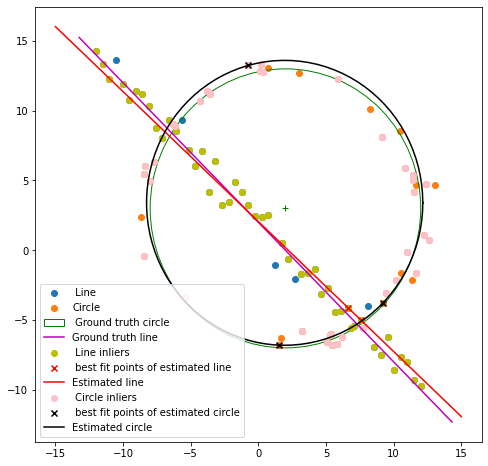

In [7]:
# Plotting
fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8))
ax . scatter ( X_line [ : , 0 ] , X_line [ : , 1 ] , label= ' Line'  )
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )
circle_gt = plt.Circle(( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= ' Ground truth circle')
ax . add_patch ( circle_gt )
ax.plot((x0_gt) , (y0_gt) , '+' , color= 'g' )
x_min , x_max = ax.get_xlim ()
x_ = np.array([x_min,x_max])
y_ = m*x_ + b
plt . plot ( x_ , y_ , color= 'm' , label= 'Ground truth line')
ax . scatter ( X[inliers_index_line][:,0] , X[inliers_index_line][:,1] , color = 'y',label= ' Line inliers'  )
ax . scatter ( np.array(best_fit_points_line)[:,0] , np.array(best_fit_points_line)[:,1] ,marker = 'x', color = 'r',label= ' best fit points of estimated line'  )
ax.plot(x_val, y_val, color='r', label='Estimated line')
ax . scatter ( X[inliers_index_circle][:,0] , X[inliers_index_circle][:,1] , color = 'pink',label= ' Circle inliers'  )
ax . scatter ( np.array(best_fit_points_circle)[:,0] , np.array(best_fit_points_circle)[:,1] , marker = 'x',color = 'k',label= ' best fit points of estimated circle'  )
ax.plot(x_val_circle, y_val_circle, color='k', label='Estimated circle')
plt . legend ()

---
Question 3
---

H=  [[ 1.53660578e+00 -1.41005151e-01  2.27999995e+02]
 [-4.52628964e-01  1.76236148e+00  3.12000000e+02]
 [-4.12414929e-04 -1.89298993e-04  1.00000000e+00]]


Text(0.5, 1.0, 'Overlayed Image')

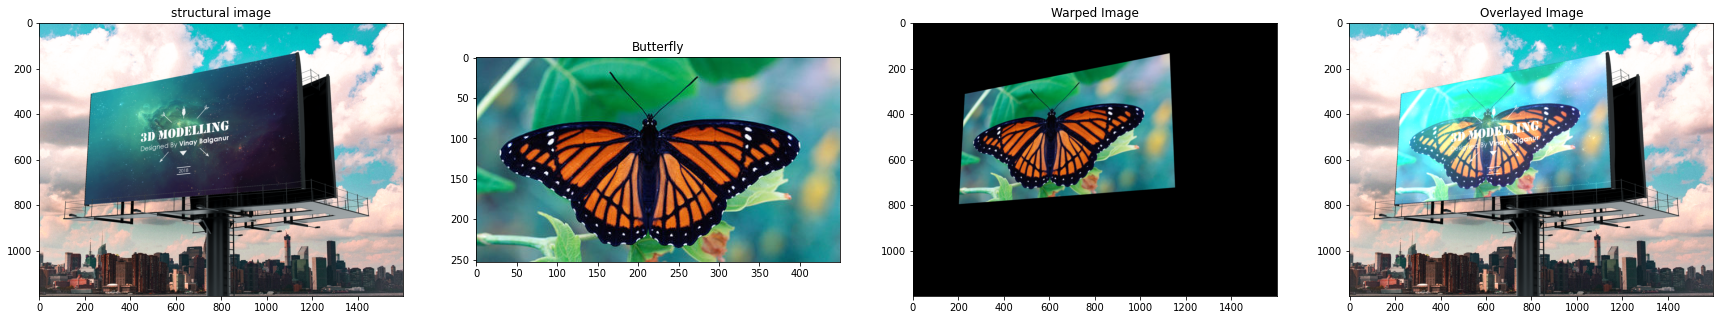

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
#Mouse clicking

k = 0
def mousePoint(event, x,y,flags,params):
    if event == cv.EVENT_LBUTTONDOWN:
        imgPoints.append([x,y,1])


def Homography(imgPoints, flagPoints):
    A = []
    for i in range(4):
        A.append([flagPoints[i][0],flagPoints[i][1],flagPoints[i][2],0,0,0,
        -imgPoints[i][0]*flagPoints[i][0],-imgPoints[i][0]*flagPoints[i][1],-imgPoints[i][0]*flagPoints[i][2]])
        A.append([0,0,0,flagPoints[i][0],flagPoints[i][1],flagPoints[i][2],
        -imgPoints[i][1]*flagPoints[i][0],-imgPoints[i][1]*flagPoints[i][1],-imgPoints[i][1]*flagPoints[i][2]])
    A = np.array(A,dtype = np.float64)
    AAT = A.T @ A
    w, v = np.linalg.eig(AAT)
    H = v[:, np.argmin(w)]
    H = H.reshape((3,3))
    H = H/H[-1,-1]
    return H

img = cv.imread('display.png',cv.IMREAD_ANYCOLOR)
cv.imshow("IMG",img)
imgPoints = []
cv.setMouseCallback("IMG",mousePoint)
k = cv.waitKey(0)
if k ==ord('q'): 
    cv.destroyAllWindows()


imgFlag = cv.imread('butterfly.jpg',cv.IMREAD_ANYCOLOR)
flagheight,flagWidth = imgFlag.shape[0],imgFlag.shape[1]
flagPoints = np.array([[0,0,1],[flagWidth,0,1],[flagWidth,flagheight,1],[0,flagheight,1]])
imgPoints = np.array(imgPoints)
H = Homography(imgPoints,flagPoints)
print('H= ',H)

rows,cols,ch = img.shape
warpedImg = cv.warpPerspective(imgFlag,H,(cols,rows))
overlayImg = cv.add(img, warpedImg)
fig,ax = plt.subplots(1,4,figsize = (30,15))
warpedImg = cv.cvtColor(warpedImg, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgFlag = cv.cvtColor(imgFlag, cv.COLOR_BGR2RGB)
overlayImg = cv.cvtColor(overlayImg, cv.COLOR_BGR2RGB)

ax[0].imshow(img)
ax[0].set_title("structural image")
ax[1].imshow(imgFlag)
ax[1].set_title("Butterfly")
ax[2].imshow(warpedImg)
ax[2].set_title("Warped Image")
ax[3].imshow(overlayImg)
ax[3].set_title("Overlayed Image")

---
Question 4
---

In [5]:
#Question 4

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

def siftMatchPoints(img1,img2):
    sift = cv.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(descriptors_1,descriptors_2,k=2)
    pts1 = []
    pts2 = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            pts2.append(keypoints_2[m.trainIdx].pt)
            pts1.append(keypoints_1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    src = np.concatenate((pts1,np.ones((pts1.shape[0],1))),axis=1)
    dst = np.concatenate((pts2,np.ones((pts2.shape[0],1))),axis=1)
    return src,dst

def RansacHomography(src,dst):

    numOfIn = 0
    inS = []
    inD = []
    for J in range(100):
        #generate 4 random numbers for choose 4 points 
        randInt1,randInt2,randInt3,randInt4 = np.random.randint(0,2000,4)%(src.shape[0])
        while randInt1==randInt2 or randInt2==randInt3 or randInt3==randInt1 or randInt4==randInt1 or randInt3==randInt4 or randInt2==randInt4:
            randInt1,randInt2,randInt3,randInt4 = np.random.randint(0,2000,4)%(src.shape[0])

        src1 = np.array([src[randInt1],src[randInt2],src[randInt3],src[randInt4]])
        dst1 = np.array([dst[randInt1],dst[randInt2],dst[randInt3],dst[randInt4]])
        A = []
        for i in range(src1.shape[0]):
            A.append([src1[i][0],src1[i][1],src1[i][2],0,0,0,-dst1[i][0]*src1[i][0],-dst1[i][0]*src1[i][1],-dst1[i][0]*src1[i][2]])
            A.append([0,0,0,src1[i][0],src1[i][1],src1[i][2],-dst1[i][1]*src1[i][0],-dst1[i][1]*src1[i][1],-dst1[i][1]*src1[i][2]])
        #find H
        A = np.array(A)
        AAT = A.T @ A
        w,v = np.linalg.eig(AAT)
        H = v[:, np.argmin(w)]
        H = H.reshape((3,3))
        H = H/H[-1,-1]
        #find number of inliers
        epsilon = 25
        count = 0
        inlierss = []
        inliersd = []
        for k in range(src.shape[0]):
            x_ = H@src[k,:].reshape(3, 1)
            x_ = x_ [:2].reshape(1, 2)[0]
            x__ = (dst[k,0:2].reshape(1, 2)[0]-x_)

            if  abs(x__[0])< epsilon and abs(x__[1]) < epsilon:

                count += 1
                inlierss.append(src[k,:])
                inliersd.append(dst[k,:])
        
        #select occassion of  highest number of inliers    
        if numOfIn < count:
            numOfIn = count
            inS = inlierss.copy()
            inD = inliersd.copy()
            
    inS = np.array(inS.copy())
    inD = np.array(inD.copy())

    src1 = inS.copy()
    dst1 = inD.copy()
    return src1,dst1

#Calculate H
def CalcH(src1,dst1):
    src1,dst1 = RansacHomography(src1,dst1)
    A = []
    for i in range(src1.shape[0]):
        A.append([src1[i][0],src1[i][1],src1[i][2],0,0,0,-dst1[i][0]*src1[i][0],-dst1[i][0]*src1[i][1],-dst1[i][0]*src1[i][2]])
        A.append([0,0,0,src1[i][0],src1[i][1],src1[i][2],-dst1[i][1]*src1[i][0],-dst1[i][1]*src1[i][1],-dst1[i][1]*src1[i][2]])
    A = np.array(A)
    AAT = A.T @ A
    w,v = np.linalg.eig(AAT)
    H = v[:, np.argmin(w)]
    H = H.reshape((3,3))
    H = H/H[-1,-1]
    return H
    
img1 = cv.imread('img1.ppm')  
img2 = cv.imread('img2.ppm')
img3 = cv.imread('img3.ppm')  
img4 = cv.imread('img4.ppm')
img5 = cv.imread('img5.ppm')
pts1,pts2 = siftMatchPoints(img1,img2)
pts1,pts2 = RansacHomography(pts1,pts2)
H1 = CalcH(pts1,pts2)
pts3,pts4 = siftMatchPoints(img2,img3)
pts3,pts4 = RansacHomography(pts3,pts4)
H2 = CalcH(pts3,pts4)
pts5,pts6 = siftMatchPoints(img3,img4)
pts5,pts6 = RansacHomography(pts5,pts6)
H3 = CalcH(pts5,pts6)
pts7,pts8 = siftMatchPoints(img4,img5)
pts7,pts8 = RansacHomography(pts7,pts8)
H4 = CalcH(pts7,pts8)
H = H4@H3@H2@H1
im1to5 = cv.warpPerspective(img1,H,(img5.shape[1],img5.shape[0]))
im1to5 = cv.cvtColor(im1to5, cv.COLOR_BGR2RGB)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

In [6]:
print('H= ',H) 

givenHomographyInDataset = np.array([[6.2544644e-01  , 5.7759174e-02  , 2.2201217e+02],
   [2.2240536e-01 ,  1.1652147e+00 , -2.5605611e+01],
   [4.9212545e-04 , -3.6542424e-05  , 1.0000000e+00]])
print('SSD between calculated H and given homography matrix: ',sum(sum((np.square(H-givenHomographyInDataset)))))

H=  [[ 6.14375532e-01  5.71611044e-02  2.20169352e+02]
 [ 2.16200085e-01  1.13868134e+00 -2.17091111e+01]
 [ 4.81366585e-04 -5.82198508e-05  9.93281939e-01]]
SSD between calculated H and given homography matrix:  18.579599256096547


Text(0.5, 1.0, 'Stiched Image')

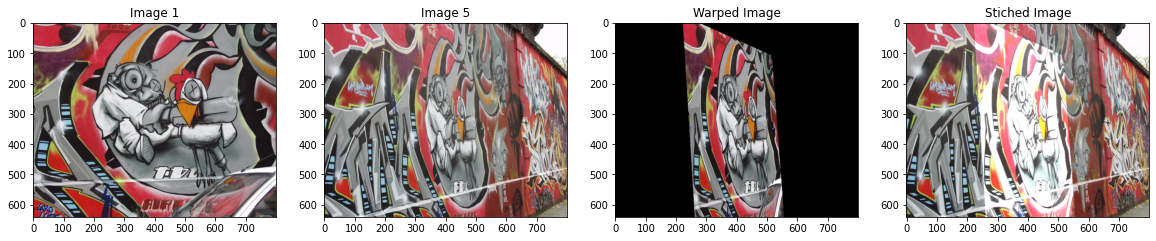

In [7]:
fig,ax = plt.subplots(1,4,figsize = (20,15))
img6 = cv.add(img5,im1to5)
ax[0].imshow(img1)
ax[0].set_title("Image 1")
ax[1].imshow(img5)
ax[1].set_title("Image 5")
ax[2].imshow(im1to5)
ax[2].set_title("Warped Image")
ax[3].imshow(img6)
ax[3].set_title("Stiched Image")